In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
#build the dataset

block_size = 3 #context size

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #update context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
#Initializing parameters

dim = 10 #dimensionality of the embedding space
n_hidden = 200 #number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647) #seed
C = torch.rand((27,dim), generator = g) # embedding matrix #we try higher dimensional embeddings

#hidden layer
W1 = torch.rand((dim * block_size, n_hidden), generator = g) * (5/3) / ((dim * block_size) ** 0.5)   # Scaling factor from Kaiming Init. Unsaturates activations
#b1 = torch.rand(n_hidden, generator = g) * 0.01 #we don't add this bias layer as it will be absorbed by the batch normalization

#out layer
W2 = torch.rand((n_hidden,27), generator = g) * 0.01
b2 = torch.rand(27, generator = g) * 0

#batch normalization parameters
bngain = torch.ones((1,n_hidden)) #scale batchnorm
bnbias = torch.zeros((1,n_hidden)) #shifts batchnorm
bnmean_running = torch.zeros((1, n_hidden)) #stores the mean of the batches during training
bnstd_running = torch.ones((1,n_hidden)) #stores the std of the batches during training

#Parameters
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) #tot number of params

12097

In [17]:
lossi = []
max_steps = 200000
batch_size = 32
#training params
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[Xtr[ix]] #embedding characters in minibatch into vectors
    embcat = emb.view(-1, dim * block_size) #concatenate the vectors
    
    #Linear Layer
    hpreact = embcat @ W1 #hidden layer pre-activation 

    #BatchNorm layer-----------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # implementing batch normalization

    with torch.no_grad(): #Estimates mean and std of the dataset. updates mean and std without storing gradients. No need to calculate mean and std of entire dataset afterward.
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
    #---------------------------------------------------------------
    #Non-linearity
    h = torch.tanh(hpreact) #activations of hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Ytr[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0
    loss.backward()

    #update parameters
    #lr0 = 0.5 # initial lr
    #r = 0.0001 # decay rate
    #lr = lr0 / (1 + r*i) # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, lr: {lr}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2994, lr: 0.1
  10000/ 200000: 2.3129, lr: 0.1
  20000/ 200000: 2.2850, lr: 0.1
  30000/ 200000: 1.9766, lr: 0.1
  40000/ 200000: 2.4136, lr: 0.1
  50000/ 200000: 2.2720, lr: 0.1
  60000/ 200000: 2.1133, lr: 0.1
  70000/ 200000: 2.3048, lr: 0.1
  80000/ 200000: 2.3263, lr: 0.1
  90000/ 200000: 1.9251, lr: 0.1
 100000/ 200000: 2.0038, lr: 0.01
 110000/ 200000: 2.0146, lr: 0.01
 120000/ 200000: 2.0921, lr: 0.01
 130000/ 200000: 2.0410, lr: 0.01
 140000/ 200000: 1.8752, lr: 0.01
 150000/ 200000: 2.1760, lr: 0.01
 160000/ 200000: 2.0601, lr: 0.01
 170000/ 200000: 1.9513, lr: 0.01
 180000/ 200000: 2.0287, lr: 0.01
 190000/ 200000: 2.1148, lr: 0.01


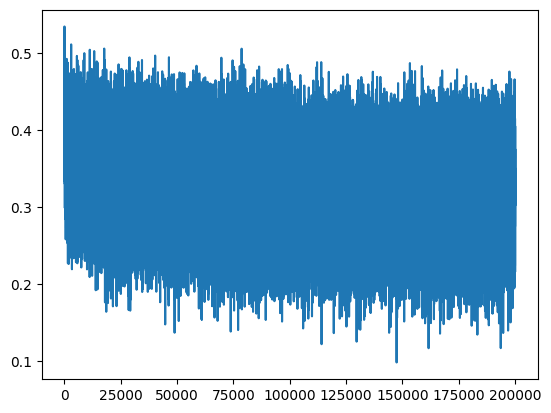

In [18]:
plt.plot(lossi)

In [14]:
#This cell is not needed anymore as now the mean and std are calculated during training.
#calibrate the batch normalization at the end of the training
'''
with torch.no_grad():
    #pass the whole training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean and std of the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)
'''

'\nwith torch.no_grad():\n    #pass the whole training set\n    emb = C[Xtr]\n    embcat = emb.view(emb.shape[0], -1)\n    hpreact = embcat @ W1 + b1\n    #measure the mean and std of the entire training set\n    bnmean = hpreact.mean(0, keepdim = True)\n    bnstd = hpreact.std(0, keepdim = True)\n'

In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(-1, dim * block_size) #concatenate the vectors
  hpreact = embcat @ W1 + b1 #hidden layer pre-activation 
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # now using fixed avg and mean params in batch normalization for whole training dataset
  h = torch.tanh(hpreact) # (N, N_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0600297451019287
val 2.102729558944702


In [17]:
def generate_names():
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] #(1, block_size, dim of embedding)
        embcat = emb.view(-1, dim * block_size) #concatenate the vectors
        
        hpreact = embcat @ W1 + b1 
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias #batchnorm

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item() #samples from prob distribution
        context = context[1:] + [ix]
        if ix == 0:
            return (''.join(itos[i] for i in out))
        out.append(ix)

for _ in range(10):
    print(generate_names())

juluwa
basza
nechar
jaylah
zamiah
sulajon
nistianna
liley
ayanna
biyl
